In [1]:
#importing libraries

import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
spot = pd.read_csv("spotify_millsongdata.csv")

In [3]:
spot.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [4]:
spot.shape

(57650, 4)

In [5]:
spot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [6]:
spot.isnull().sum()

artist    0
song      0
link      0
text      0
dtype: int64

In [7]:
# checking top 10 artists based on no of songs
top_art = spot['artist'].value_counts().head(10)
print('Top 10 Artists:')
print(top_art)

Top 10 Artists:
artist
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Loretta Lynn        187
Cher                187
Alabama             187
Reba Mcentire       187
Chaka Khan          186
Dean Martin         186
Name: count, dtype: int64


In [8]:
# sampling dataframe and dropping column not needed for recommendation 
spot = spot.sample(30000)
spot = spot.drop('link', axis=1).reset_index(drop=True)


In [9]:
spot.head()

,artist,song,text
0,Kris Kristofferson,Love Of Money,Chorus: \nLove of money is the root of all ev...
1,O.A.R.,Fire,"Going on forever was never the plan, \nI'm ju..."
2,Elton John,A Word In Spanish,I don't know why \nI just know I do \nI just...
3,Fleetwood Mac,Oh Daddy,"Oh Daddy, \nYou know you make me cry, \nHow ..."
4,Dan Fogelberg,Gone Too Far,World spinning out of control \nThe odds dimi...


In [10]:
# wordcloud for lyrics
lyrics = " ".join(spot['text'].dropna())
wordcloud = WordCloud(width=750, height=450, background_color='white').generate(lyrics)

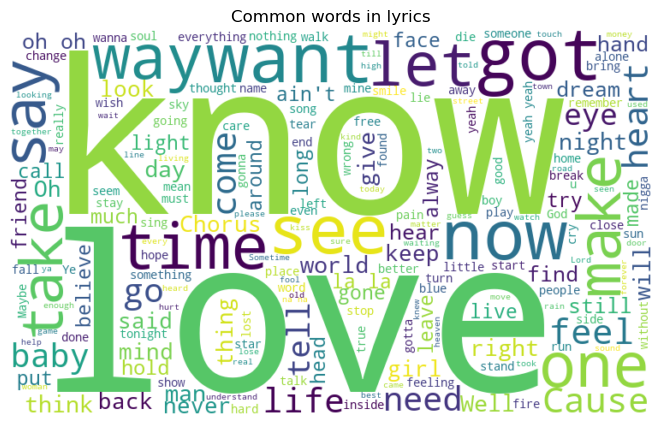

In [11]:
# visualizing the common words in the lyrics
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common words in lyrics')
plt.show()

In [12]:
# data preprocessing using nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt_tab: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [13]:
stop_words = set(stopwords.words('english')) # set removes duplicate values

In [14]:
def preprocess_text(text):
    # removing special characters and numbers
    text =re.sub(r"[^a-zA-Z\s]", "", text)
    # coverting to lowercase
    text = text.lower()
    # tokenizing and removing stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [15]:
# applying preprocessing to lyrics
spot['cleaned_text'] = spot['text'].apply(preprocess_text)

In [16]:
spot.head()

,artist,song,text,cleaned_text
0,Kris Kristofferson,Love Of Money,Chorus: \nLove of money is the root of all ev...,chorus love money root evil love money root ev...
1,O.A.R.,Fire,"Going on forever was never the plan, \nI'm ju...",going forever never plan im passing minutes st...
2,Elton John,A Word In Spanish,I don't know why \nI just know I do \nI just...,dont know know cant explain language use somet...
3,Fleetwood Mac,Oh Daddy,"Oh Daddy, \nYou know you make me cry, \nHow ...",oh daddy know make cry love dont understand oh...
4,Dan Fogelberg,Gone Too Far,World spinning out of control \nThe odds dimi...,world spinning control odds diminish every die...


In [17]:
# vectorization using tfidf

tfidf_vec = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vec.fit_transform(spot['cleaned_text']) 

In [18]:
# cosine similarity

cos_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [19]:
# creating recommendation function

def recommend_songs(song_name, cos_sim=cos_sim, spot=spot, top_n=6):
    # finding the song index
    ind = spot[spot['song'].str.lower() == song_name.lower()].index
    if len(ind) == 0:
        return "song not found in the dataset."
    ind = ind[0]
    
    # getting similarity scores
    sim_scores = list(enumerate(cos_sim[ind]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    
    # getting song indices
    song_indices = [i[0] for i in sim_scores]
    
    # return top n similar songs
    return spot[['artist', 'song']].iloc[song_indices]

In [20]:
spot['song'][3]

'Oh Daddy'

In [21]:
# test recommendation
print("Recommendations for the song 'People Make The World Go Round': ")
rec = recommend_songs('People Make The World Go Round')
print(rec)

Recommendations for the song 'People Make The World Go Round': 
            artist                         song
24767          Yes              Man In The Moon
16352      Roxette  One Is Such A Lonely Number
22732      Hollies                On A Carousel
1286   Chris Brown               Marry Go Round
12199    Van Halen                    Runaround
11173          Who          In A Hand Or A Face
